# Prediction of taxi orders for the next hour

## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## 1. Data preparation

### 1.1. Open the data file and study the general information

In [1]:
# import libs
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%config InlineBackend.figure_format = 'retina'

*Read the file and save it to the variable*

In [2]:
df_taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

*Check if the dates and times are in chronological order*

In [3]:
df_taxi.index.is_monotonic

True

*Resample data by one hour*

In [4]:
df_taxi = df_taxi.resample('1H').sum()

*Print 5 first rows*

In [5]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


*Data description:*  
There're date and number of taxi orders.

*Look at the general information of our dataset*

In [6]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


*Use describe() method for more information*

In [7]:
df_taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Conclusion

We have the number of orders for six months of 2018 from March to September for every hour.

## 2. Data Analysis

### 2.1. Non-stationary model checking (visual test)

In order to use time series forecasting models, it's necessary to convert any non-stationary series to a stationary series first. The stationary time series is a series where the mean and standard deviation do not change.

*Plot the histogram for number of orders*

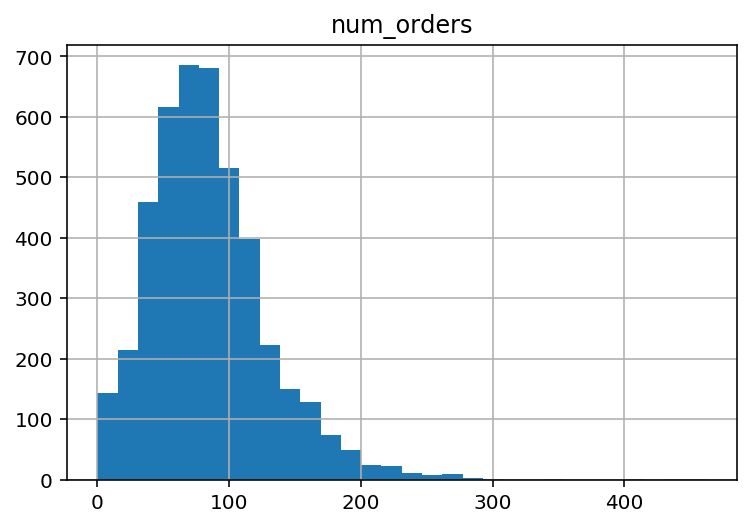

In [8]:
df_taxi.hist(bins=30);

We see the bell curve-like shape of the Gaussian distribution with a longer right tail.

*Look at our plot by months*

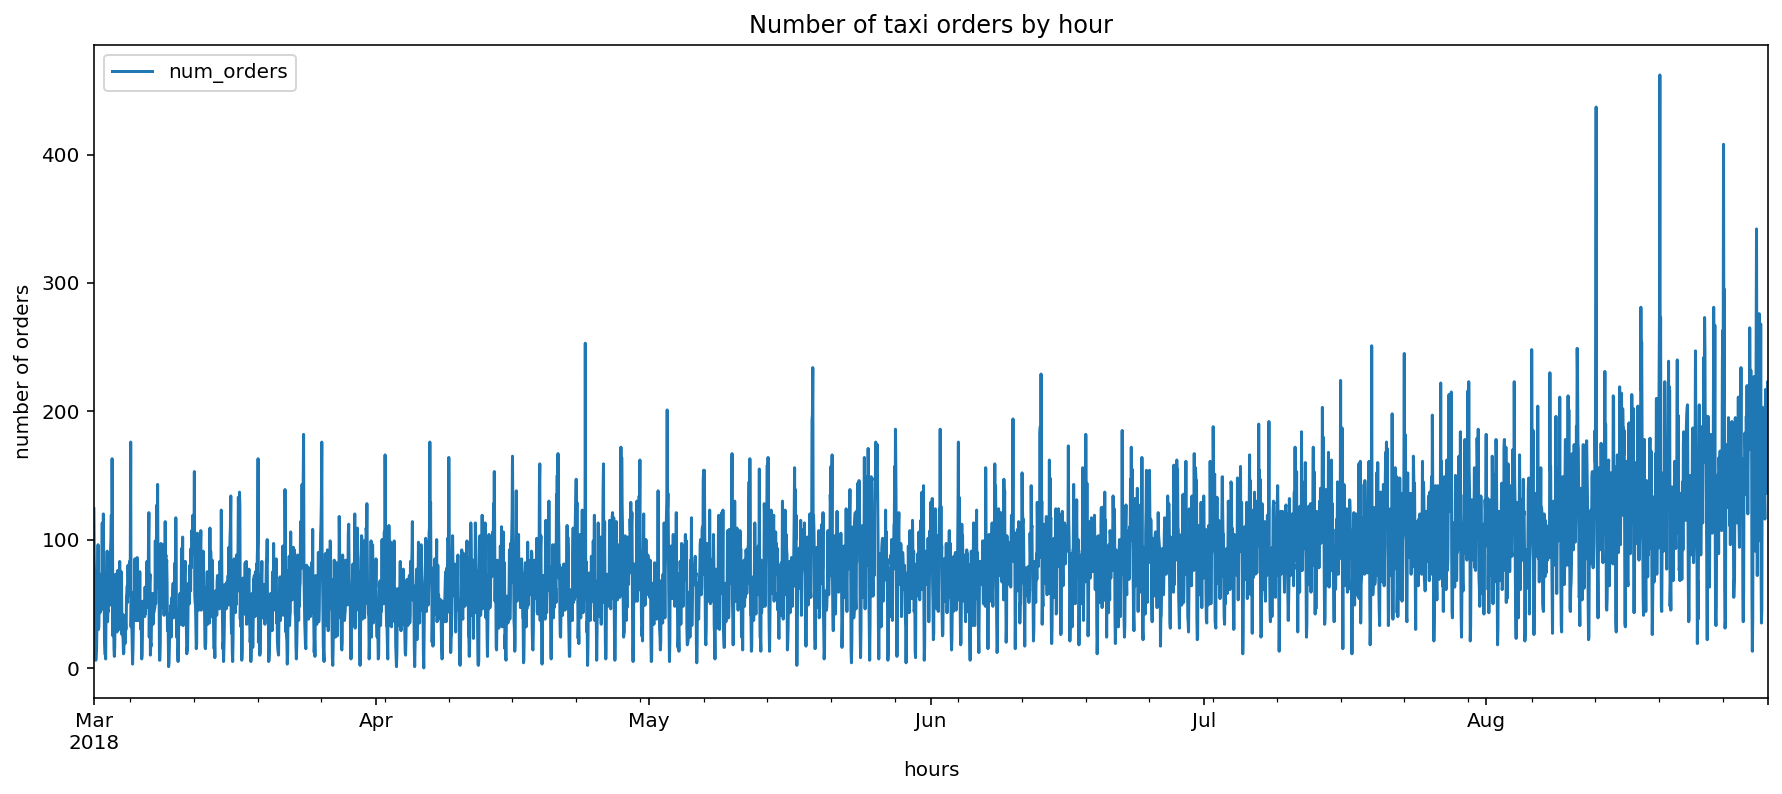

In [9]:
ax = df_taxi.plot(figsize=(15, 6))
ax.set_xlabel("hours")
ax.set_ylabel("number of orders")
plt.title('Number of taxi orders by hour');

*To reduce the fluctuations in a time series, let's look at trend, seasonality and residuals*

In [10]:
# takes a time series and returns an instance of the DecomposeResult class
decomposed = seasonal_decompose(df_taxi)

*Plot the graphs for trend, seasonality and residuals*

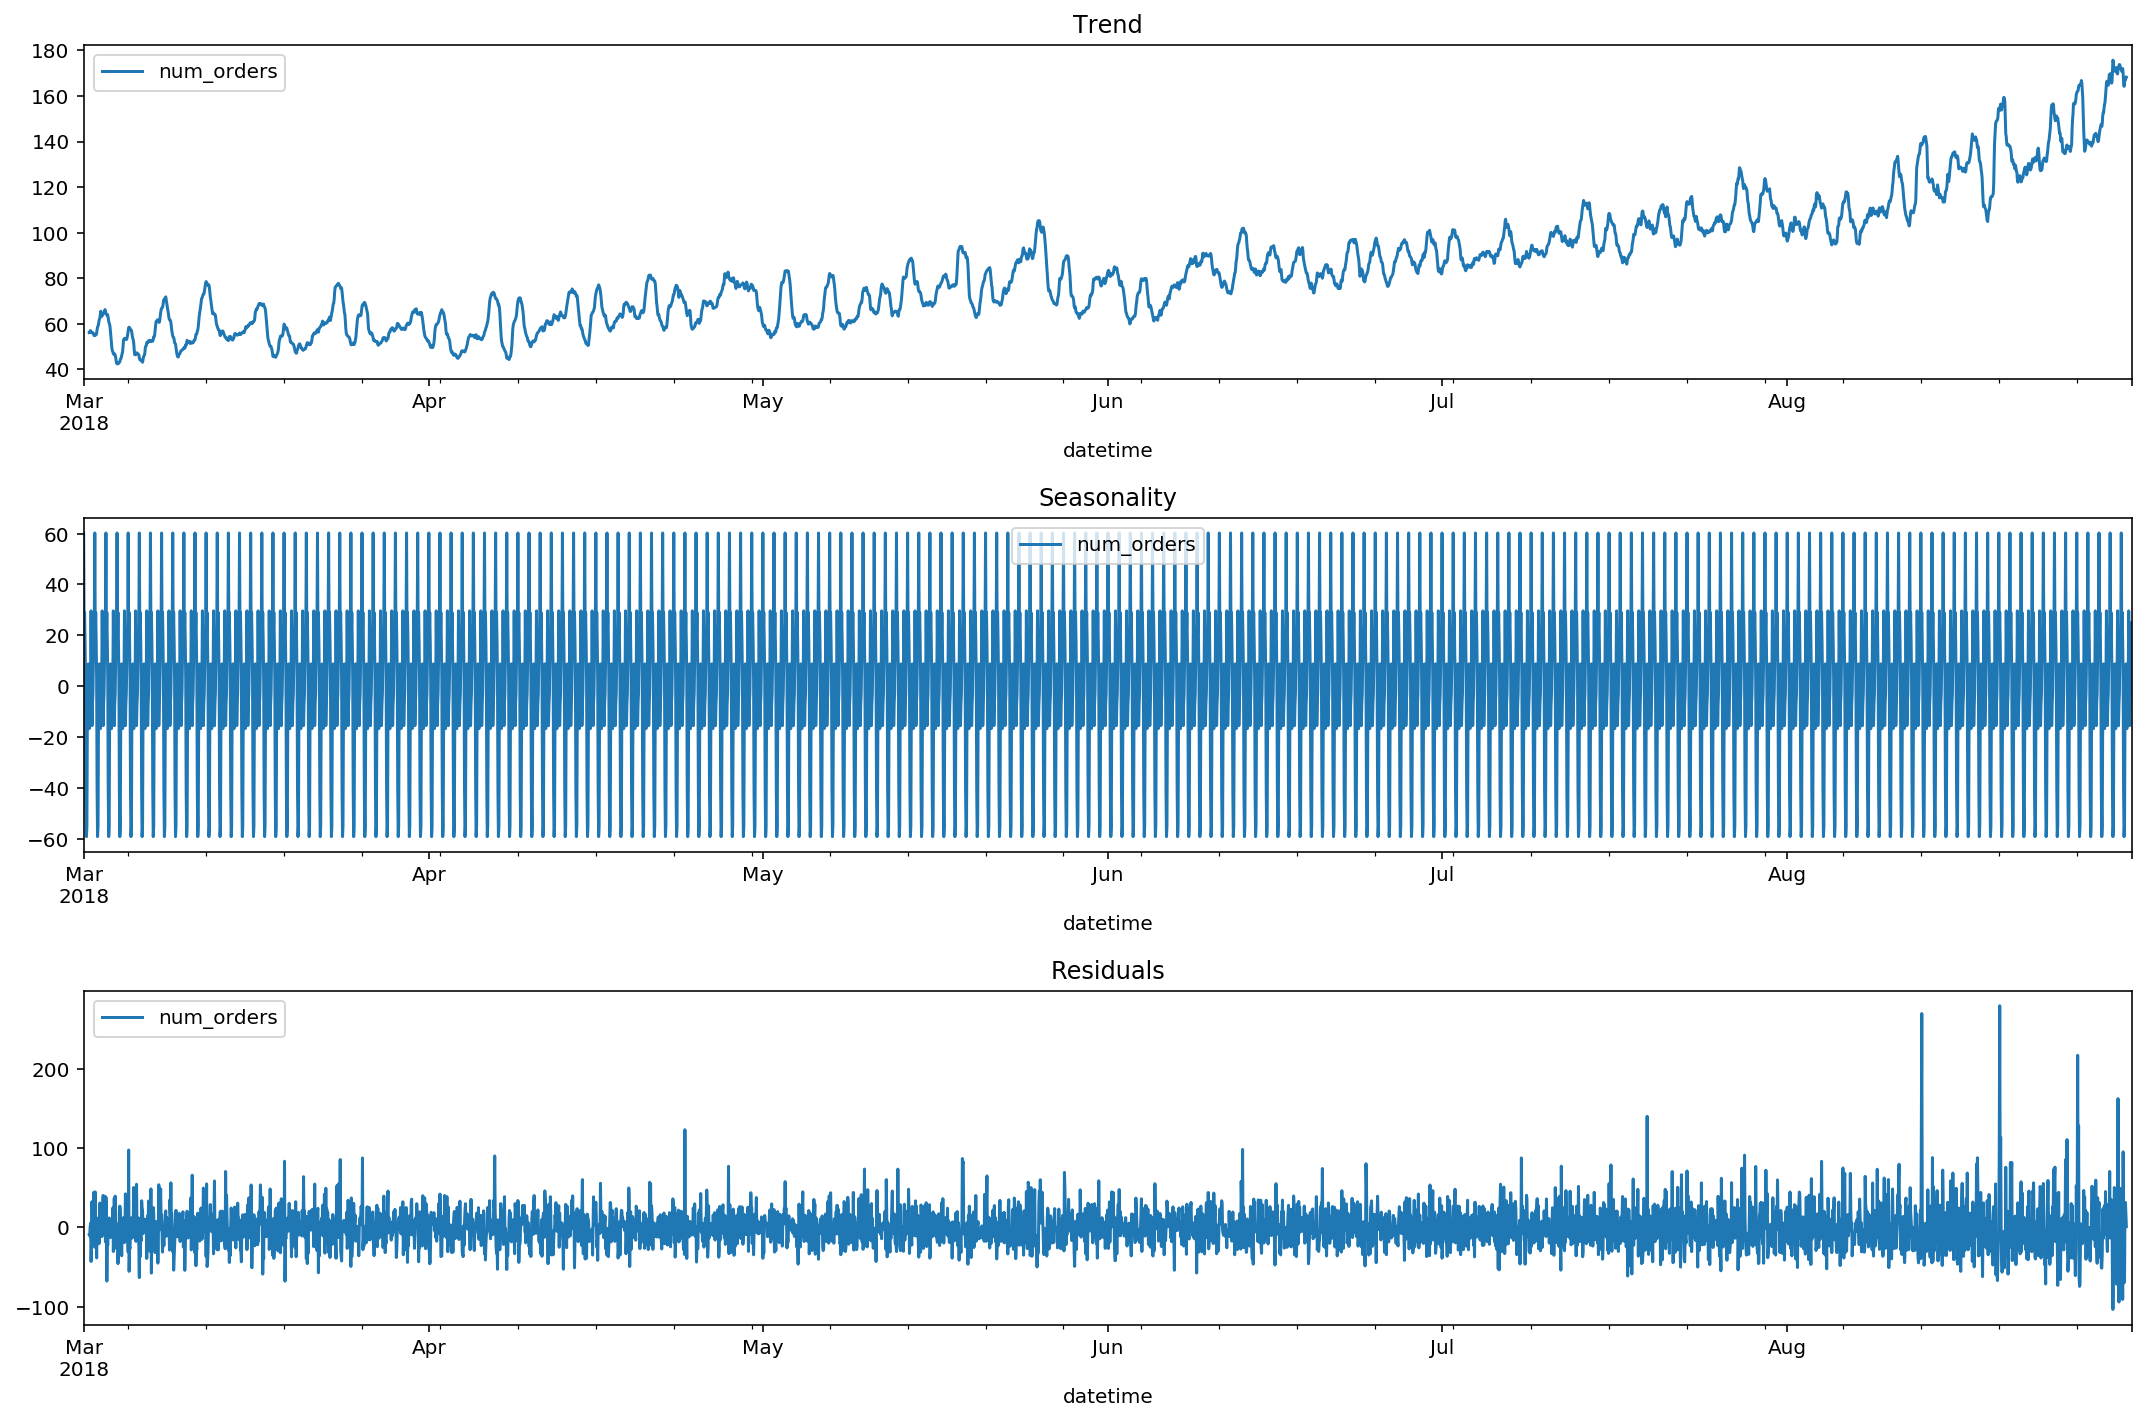

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(311)

# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

*Plot the graph of the seasonal component for the one day of March 2018*

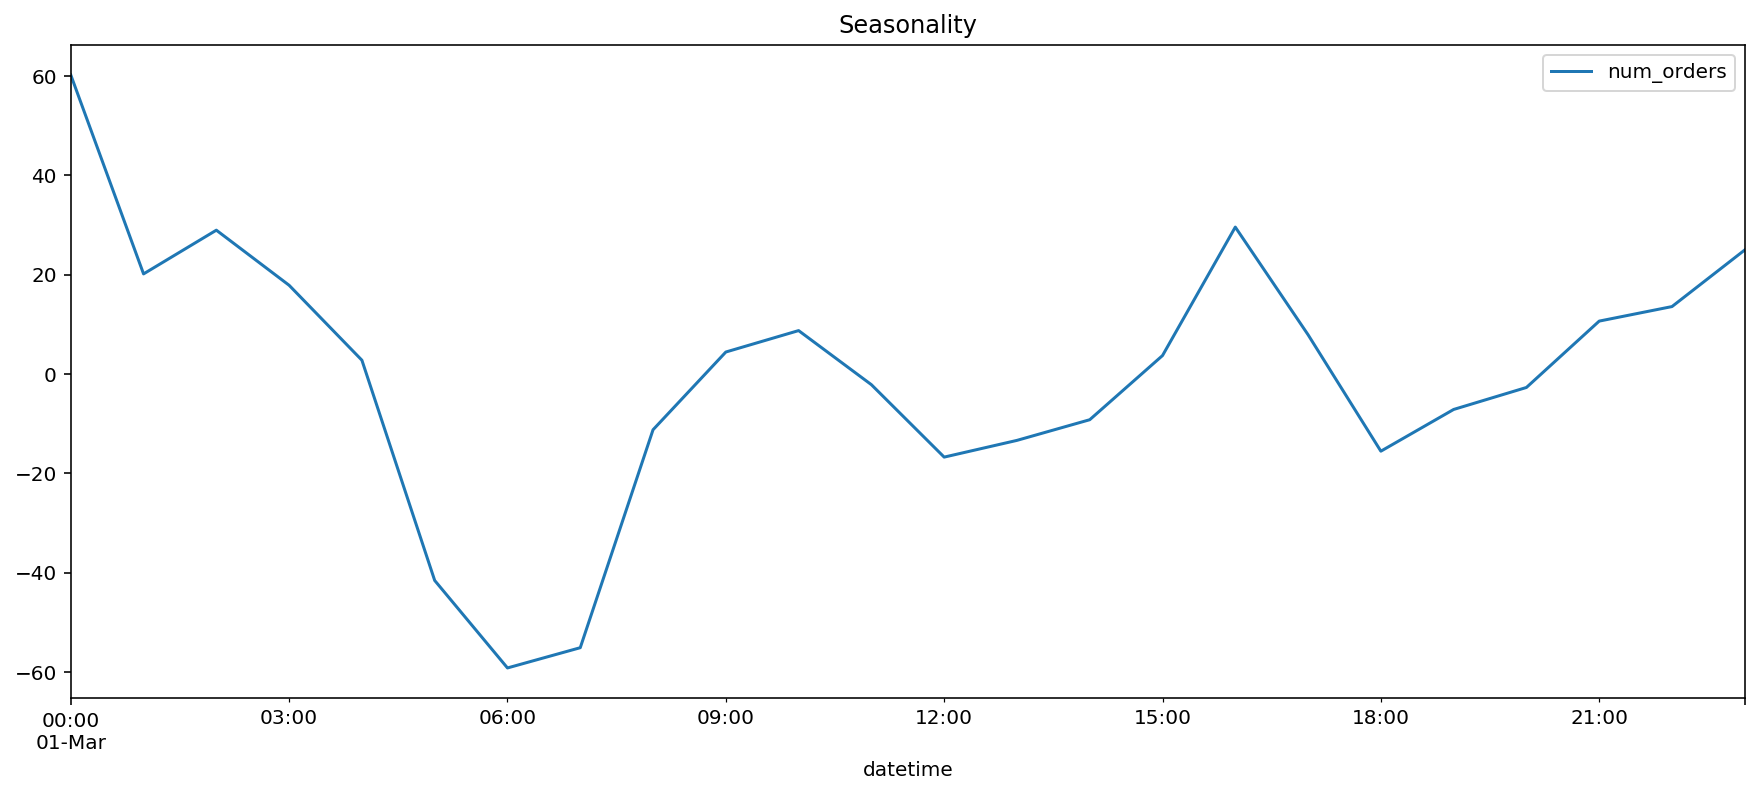

In [12]:
decomposed.seasonal['2018-03-01'].plot(figsize=(15, 6))
plt.title('Seasonality');

### Conclusion

- We see the bell curve-like shape of the Gaussian distribution with a longer right tail, but the mean changes on the trend plot. Therefore this visual approach might not always give accurate results. It's better to confirm the observations using statistical Dickey-Fuller test.
- The number of taxi orders is lowest at 6 a.m. Everyone's still asleep.

### 2.2. Non-stationary model checking (Dickey-Fuller test)

Apply the Dickey-Fuller test to see if we have a stationary process

- *Null Hypothesis (H0):*  
The time series has a unit root.
- *Alternate Hypothesis (H1):*  
The time series does not have a unit root.


- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [13]:
# reshape data and use adfuller function from "statsmodels.tsa.seasonal"
result = adfuller(np.reshape(df_taxi.values, len(df_taxi.values)))

In [14]:
# print ADF Statistic, p-value and critical Values
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))
print('Critical Values:')
for key, val in result[4].items():
    print('\t{}: {:.2f}'.format(key, val))

ADF Statistic: -3.07
p-value: 0.03
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


p-value <= 0.05, but 1% critical value (-3.43) is lower than ADF Statistic (-3.07). We can reject the null hypothesis with only a significance level of less than 5%. So fix our data.

*To make a series stationary, we can take the differences of its values*

In [15]:
# make a copy of origin dataframe
df_taxi_origin = df_taxi.copy()

# use shift() method to find the differences of time series
df_taxi = df_taxi - df_taxi.shift()
df_taxi.dropna(inplace=True)

*Try Dickey-Fuller test with new data*

In [16]:
# reshape data and use adfuller function from "statsmodels.tsa.seasonal"
result = adfuller(np.reshape(df_taxi.values, len(df_taxi.values)))

In [17]:
# print ADF Statistic, p-value and critical Values
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))
print('Critical Values:')
for key, val in result[4].items():
    print('\t{}: {:.2f}'.format(key, val))

ADF Statistic: -15.79
p-value: 0.00
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


p-value <= 0.05, critical values are lower than ADF Statistic.

*Look at our plot by months*

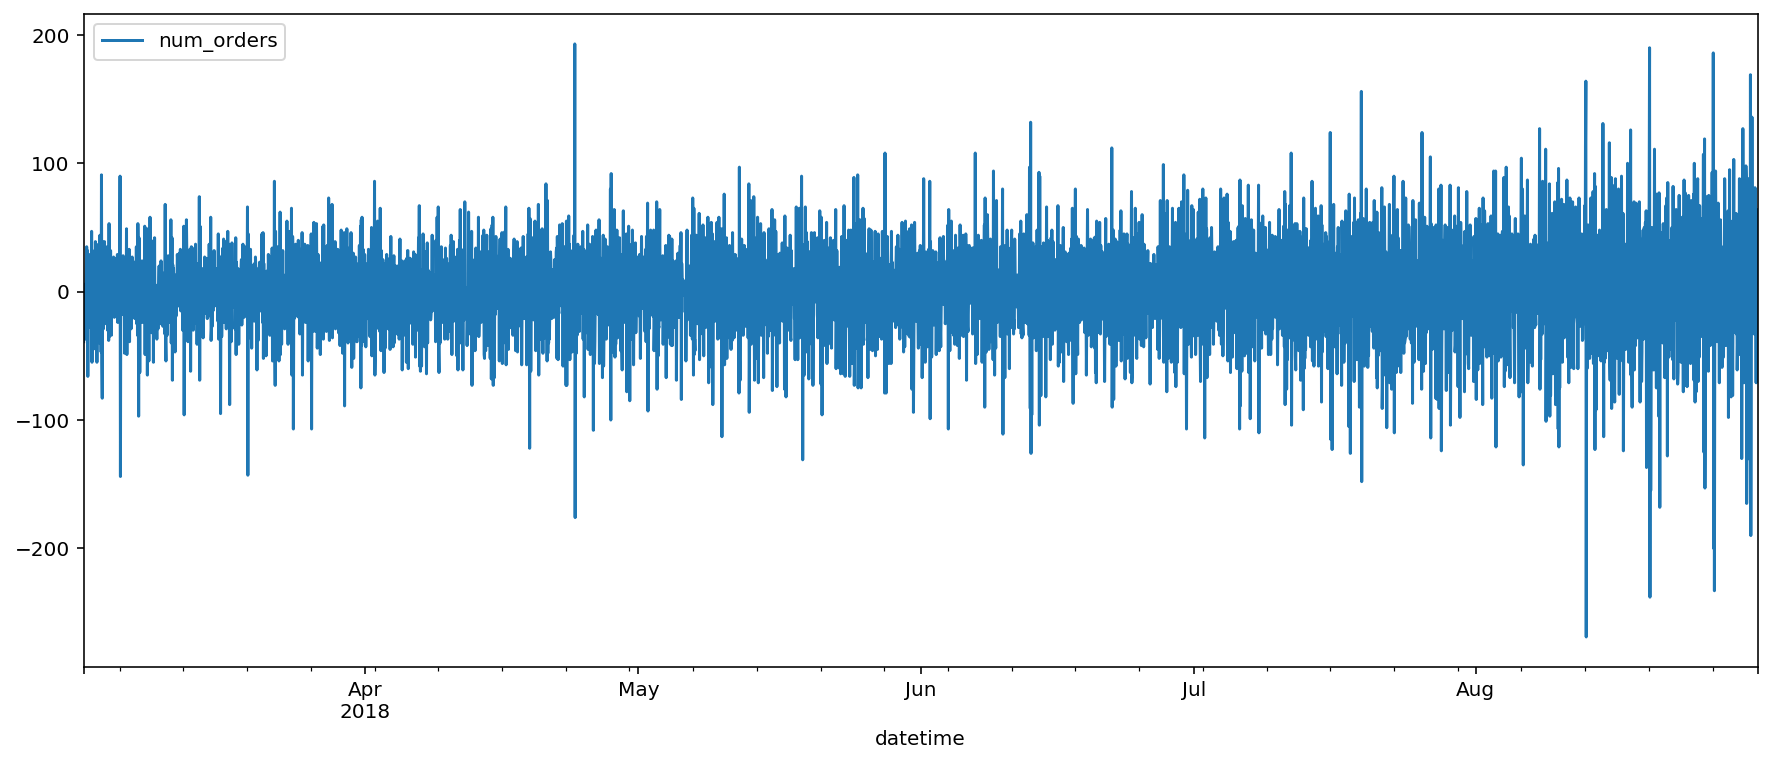

In [18]:
df_taxi.plot(figsize=(15, 6));

### Conclusion

Thus our time series became stationary.

## 3. Training

### 3.1. Feature and target preparation

*Create features for a one-step forecast horizon of one hour*

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    # make "calendar features"
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # make "lag features"
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    #make "rolling mean feature"
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

*Call our make_features function with max_lag = 10, rolling_mean_size = 12*

In [20]:
make_features(df_taxi, 4, 10)

*Create train, valid and test dataframes*

In [21]:
train_valid, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

*Check the dataframes sizes*

In [22]:
for df in (train, valid, test):
    print(df.shape[0])

3566
397
442


*Create features and target datasets*

In [23]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### 3.2. Choosing the best model

*LinearRegression model*

In [24]:
model = LinearRegression() # create model class
model.fit(features_train, target_train) # fit the model
predicted_train = model.predict(features_train) # predict values for train data
predicted_valid = model.predict(features_valid) # predict values for valid data

# print RMSE for train and valid
print("RMSE for the training set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE for the valid set: ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE for the training set: 30.267117903100345
RMSE for the valid set:  42.768108483847236


*DecisionTreeRegressor*

In [25]:
model = DecisionTreeRegressor(max_depth=6, random_state=42) # create model class
model.fit(features_train, target_train) # fit the model
predicted_train = model.predict(features_train) # predict values for train data
predicted_valid = model.predict(features_valid) # predict values for valid data

# print RMSE for train and valid
print("RMSE for the training set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE for the valid set: ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE for the training set: 24.395773096792794
RMSE for the valid set:  39.35240194533833


*RandomForestRegressor*

In [26]:
model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42) # create model class
model.fit(features_train, target_train) # fit the model
predicted_train = model.predict(features_train) # predict values for train data
predicted_valid = model.predict(features_valid) # predict values for valid data

# print RMSE for train and valid
print("RMSE for the training set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE for the valid set: ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE for the training set: 22.986045757732136
RMSE for the valid set:  36.94641960814292


*LGBMRegressor*

In [27]:
model = lgb.LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) # create model class
model.fit(features_train, target_train) # fit the model
predicted_train = model.predict(features_train) # predict values for train data
predicted_valid = model.predict(features_valid) # predict values for valid data

# print RMSE for train and valid
print("RMSE for the training set:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE for the valid set: ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE for the training set: 17.9722499586722
RMSE for the valid set:  34.05824856369857


### Conclusion

LGBMRegressor gives the best results.

## 4. Testing

In [28]:
model = lgb.LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) # create model class
model.fit(features_train, target_train) # fit the model
predicted_test = model.predict(features_test) # predict values for test data

# print RMSE for test
print("RMSE for the test set:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE for the test set: 45.81185595908174


*Calculate RMSE with origin dataframe*

*Call our make_features function with max_lag = 10, rolling_mean_size = 12*

In [29]:
make_features(df_taxi_origin, 4, 10)

*Create train, valid and test dataframes*

In [30]:
train, test = train_test_split(df_taxi_origin, shuffle=False, test_size=0.1)
train = train.dropna()

*Check the dataframes sizes*

In [31]:
for df in (train, test):
    print(df.shape[0])

3964
442


*Create features and target datasets*

In [32]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

*Calculate RMSE*

In [33]:
model = lgb.LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) # create model class
model.fit(features_train, target_train) # fit the model
predicted_test = model.predict(features_test) # predict values for test data

# print RMSE for test
print("RMSE for the test set:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE for the test set: 43.66978678636954


## 5. Overall conclusion

We have the best RMSE with LGBMRegressor model (45.44).